# Frequent users 

The objective of this notebook is to select frequent users. A frequent users is define as a travel sequence between Jan/01/2020 and Mar/08/2020 that has the following characteristictis: 
- +15 transactions 
- +10 active days 
- Daily average transactions less than 5 
- Less than 200 transactions 

In [1]:
import pyspark as ps
from pyspark.sql.functions import *
from pyspark.sql import * 
sc = ps.SparkContext(appName="frequent_users")

In [2]:
spark = SparkSession.builder\
        .master("local") \
        .appName("frequent_users") \
        .getOrCreate()

In [3]:
from os import path
import warnings
warnings.filterwarnings('ignore')

import time 
import random 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import glob


import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import pow, col, sqrt
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.types import *

## Functions definitions

In [4]:
def travel_sequence_characteristics(transactions):
    ''' Returns the travel sequence characteristics for each smartcard id
    Input: 
    - transactions: PySpark dataframe. Contains all the smartcard transactions 
    - id_mapping: New ids for each smartcard 
    - fraction: Float. Fraction to create a random sample of transactions
    '''
    
    aggregations = [count(col('fechatransaccion')).alias('transactions'),
        expr('count(distinct fechatransaccion)').alias('active_days'),
        max(col('date')).alias('max_day'), 
        min(col('date')).alias('min_day')]

#     df = transactions.sample(withReplacement=False, fraction=fraction, seed=0)\
#         .withColumn('date', to_date(unix_timestamp(col('fechatransaccion'), 'yyyyMMdd').cast("timestamp")))\
#         .filter(col('date').between('2020-01-01','2020-03-08'))\
#         .groupBy('card_id').agg(*aggregations)\
#         .transform(lambda df: time_spam(df,'min_day','max_day','time_spam' ))\
#         .transform(lambda df: col_division(df, 'transactions', 'time_spam', 'trans_per_timespam'))\
#         .transform(lambda df: col_division(df, 'transactions', 'active_days', 'trans_per_activeday'))
    
    df = transactions.withColumn('date', to_date(unix_timestamp(col('fechatransaccion'), 'yyyyMMdd').cast("timestamp")))\
            .filter(col('date').between('2020-01-01','2020-03-08'))\
            .groupBy('card_id').agg(*aggregations)\
            .transform(lambda df: time_spam(df,'min_day','max_day','time_spam' ))\
            .transform(lambda df: col_division(df, 'transactions', 'time_spam', 'trans_per_timespam'))\
            .transform(lambda df: col_division(df, 'transactions', 'active_days', 'trans_per_activeday'))
    
    return df

In [5]:
def time_spam(df, lower_limit = 'max_day', upper_limit = 'min_day', name = 'time_spam'):
    ''' Returns the time difference between lower and upper limit. 
    Input: 
    - df: Pyspark dataframe 
    - lower_limit: Col name where lower limit is stored 
    - upper_limit: Col name where upper limit is stored
    - name: Name of the resulting column
    '''
    return df.withColumn(name, datediff(df[upper_limit], df[lower_limit]) + 1)

In [6]:
def col_division(df, col1, col2, name = 'division'):
    ''' Returns the division of two columns
    Input: 
    - df: PySpark dataframe 
    - col1: str. col name of the numerator  
    - col2: str. col name of the denominator
    - name: str. name of the resulting division
    '''
    return df.withColumn(name, df[col1]/df[col2])

In [7]:
def frequent_user_filter(df):
    df_filtered = df.filter(df.transactions >= 15)\
                    .filter(df.active_days >= 10)\
                    .filter(df.trans_per_activeday <= 5)\
                    .filter(df.transactions <= 200)
    
    return df_filtered

In [8]:
def filter_frequent_users_transactions(transactions, frequent_users):
    ''' Returns a dataframe with a new colum containing new_IDs
    Input:
    - dataFrame: PySpark dataframe with a column 'numerotarjeta' as ID
    - new_ids: mapping of 'numerotarjetas' with a new (simple/shorter) id
    '''
    return transactions.join(frequent_users, on = 'card_id', how = 'right')

In [9]:
def save_to_csv(df, path):
    '''Save a pandas dataframe in a csv file '''
    df.to_csv(path, sep = ',', index = False)

## Running code 

In [10]:
output_path = '../data/output/tables/'

transactions = spark.read.option("header", "True")\
                    .option("sep", ",")\
                    .csv(output_path + 'transactions.csv/*.csv')


In [11]:
frequent_users = transactions.transform(lambda df: travel_sequence_characteristics(df)) \
                             .transform(lambda df: frequent_user_filter(df))

frequent_user_transactions = filter_frequent_users_transactions(transactions, frequent_users)


In [12]:
print('Number of frequent users:', frequent_users.count())
print('Number of Transactions for frequent users:', frequent_user_transactions.count())

Number of frequent users: 2015103
Number of Transactions for frequent users: 158254268


In [13]:
%%time
frequent_user_transactions.write.csv(output_path + 'transactions_frequent_users.csv', mode = 'overwrite', header = True)

CPU times: user 63.7 ms, sys: 37.9 ms, total: 102 ms
Wall time: 12min 25s


## Graphs 

In [14]:
travel_sequence = travel_sequence_characteristics(transactions)
travel_sequence.write.csv(output_path + 'travel_sequence.csv', mode = 'overwrite', header = True)

In [4]:
output_path = '../data/output/'
df = pd.concat(map(pd.read_csv, glob.glob(output_path + 'tables/travel_sequence.csv/*.csv')))

In [5]:
df.shape

(6303098, 8)

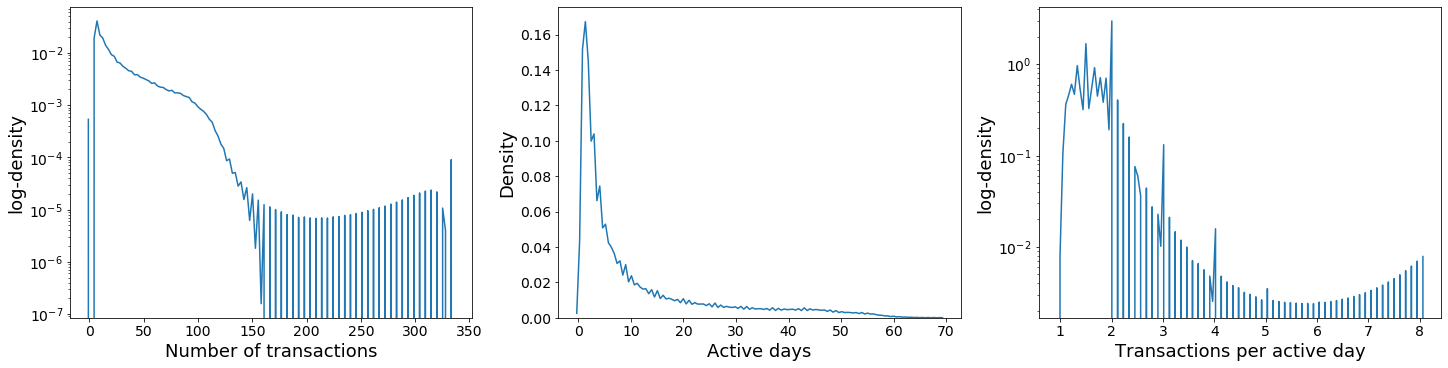

In [11]:
fig = plt.figure(constrained_layout=True, figsize = (20,5))
widths = [2,2,2]
heights = [2]

spec = fig.add_gridspec(ncols=3, nrows=1 , width_ratios=widths, height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
sns.kdeplot(df['transactions'].values, ax = ax1)
ax1.set_yscale('log')
ax1.set_xlabel('Number of transactions', fontsize = 18)
ax1.set_ylabel('log-density', fontsize = 18);


ax2 = fig.add_subplot(spec[0, 1])
sns.kdeplot(df['active_days'].values, ax = ax2)
ax2.set_xlabel('Active days', fontsize = 18)
ax2.set_ylabel('Density', fontsize = 18);

ax3 = fig.add_subplot(spec[0, 2])
sns.kdeplot(df['trans_per_activeday'].values, ax = ax3)
ax3.set_yscale('log')
ax3.set_xlabel('Transactions per active day', fontsize = 18)
ax3.set_ylabel('log-density', fontsize = 18);

fig.savefig(output_path + 'figures/figure2abc.pdf')

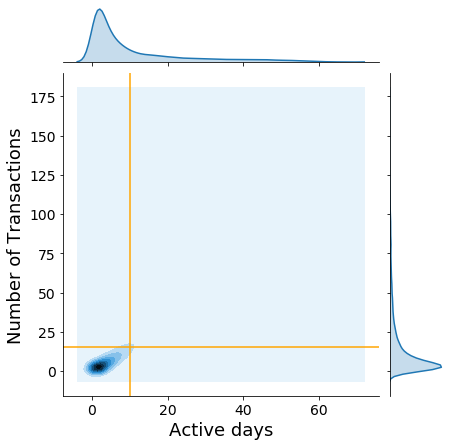

In [12]:
to_plot = df.sample(10000)
x = to_plot['active_days'].values
y = to_plot['transactions'].values
g = sns.jointplot(x = x, y = y, kind = 'kde', )
g.ax_joint.set_xlabel('Active days', fontsize = 18)
g.ax_joint.set_ylabel('Number of Transactions', fontsize = 18)
g.ax_joint.axvline(x=10, color = 'orange')
g.ax_joint.axhline(y=15, color = 'orange')

g.savefig(output_path + 'figures/figure2d.pdf')

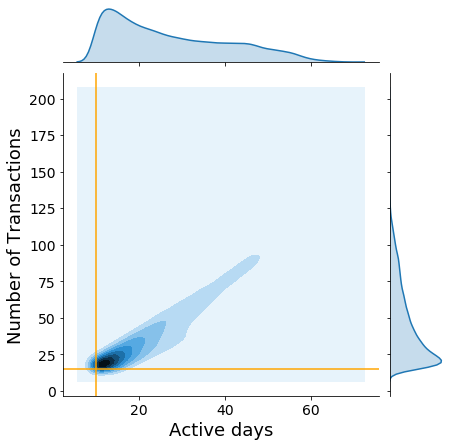

In [13]:
df1 = df[df.transactions < 200]
df1 = df1[df1.active_days >= 10]
df1 = df1[df1.transactions >= 15]
df1 = df1[df1.trans_per_activeday <= 5]

to_plot = df1.sample(100000)
x = to_plot['active_days'].values
y = to_plot['transactions'].values
g = sns.jointplot(x = x, y = y, kind = 'kde')
g.ax_joint.set_xlabel('Active days', fontsize = 18)
g.ax_joint.set_ylabel('Number of Transactions', fontsize = 18)
g.ax_joint.axvline(x=10, color = 'orange')
g.ax_joint.axhline(y=15, color = 'orange')

g.savefig(output_path + 'figures/figure2f.pdf')